# Personal Information
Name: **Ioannis Papageorgiou**

StudentID: **15050882**

Email: [**ioannis.papageorgiou2@student.uva.nl**](ioannis.papageorgiou2@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context

The data that will be used to test the model are derived using the framework of PDDLGym (https://github.com/tomsilver/pddlgym). The API of PDDLGym offers access to more than 20 domains often used in both planning and reinforcement learning applications, such as BlocksWorld (also known as Blocks), Sokoban and the Travelling Salesman problem. For each of the domains, the API can generate a problem as a series of images, as well as load the corresponding $\textit{Objects}$ which exist in the domain, and predicates (literals) which are true in each frame of the problem.

For the purpose of this thesis, we will focus fistly on the particular dataset of Blocks. We will initially explore the capabilities of the pipeline on the simple case of Blocks, as the predicates to be extracted are either unary or binary. It should be mentioned that, as the task to be performed consists a Supervised learning task with predicates as labels, each input sample of the pipeline will be a frame of the game and the output is expected to be the truth values of all predicates describing the world (binary classification).

# Data Description

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import pddlgym
from matplotlib import pyplot as plt
import imageio

Blocks, refers to the simple game of a robot having to move blocks of different colors on top of one another, in a certain order. Each move of the robot is either to pickup or drop a block which is immediately available, i.e. does not have another block on top of it. In order to visualize this concept, we can utilize the PDDLGym framework as follows.

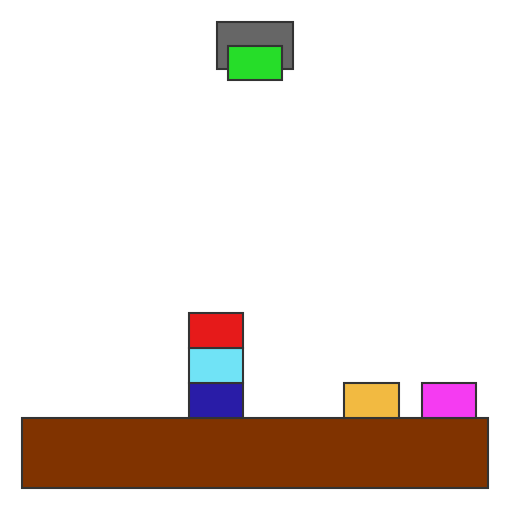

In [2]:
env = pddlgym.make("PDDLEnvBlocks-v0", seed=1) #Create the Blocks environment, use seed to ensure consistency
obs, debug_info = env.reset() #Reset and Initialize the environment
img = env.render() #Render the first frame

As can be observed from the frame, the image consists of a simple setup of 6 blocks, the robot and the table. The next step would be to see how the blocks are named, which predicates hold and what the goal is.

In [3]:
obs.objects #Print the Objects of the domain

frozenset({a:block, b:block, c:block, d:block, e:block, f:block, robot:robot})

In [4]:
obs.literals #Print all the TRUE grounded predicates for this particular state

frozenset({clear(a:block),
           clear(e:block),
           clear(f:block),
           handfull(robot:robot),
           holding(d:block),
           on(a:block,b:block),
           on(b:block,c:block),
           ontable(c:block),
           ontable(e:block),
           ontable(f:block)})

In [5]:
obs.goal #Print which literals must be true (at least) for the game to be solved

AND[on(a:block,b:block), on(b:block,c:block), on(c:block,d:block), on(d:block,e:block), on(e:block,f:block)]

This process is repeated one more time after we have the agent take an action (step) at random, to observe whether the changes are valid. As the method $\textit{env.action\_space.sample(obs)}$ samples an action completely randomly out of all available actions (possible or not), it is not guaranteed that the chosen action will have any effect.

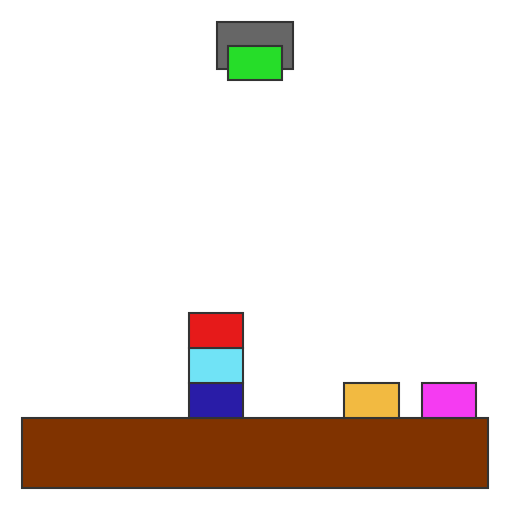

In [6]:
action = env.action_space.sample(obs) #Sample an action
obs, reward, done, info = env.step(action) #Perform the actions, receive a reward and check if the game is solved
img = env.render() #Print the next state

Next, we explore the images generated to understand their structure.

In [7]:
type(img)

numpy.ndarray

In [8]:
img.shape

(480, 480, 4)

Examining the source code of PDDLGym Blocks, it can be observed that the rendered image will always have a shape of $(480, 480, 4)$ (*render* method of https://github.com/tomsilver/pddlgym/blob/master/pddlgym/rendering/blocks.py file). In the case where the number of blocks is less than 6, the size of the blocks (and the robot) is bigger in order to maintain this size. This can be observed in the following example.

(480, 480, 4)


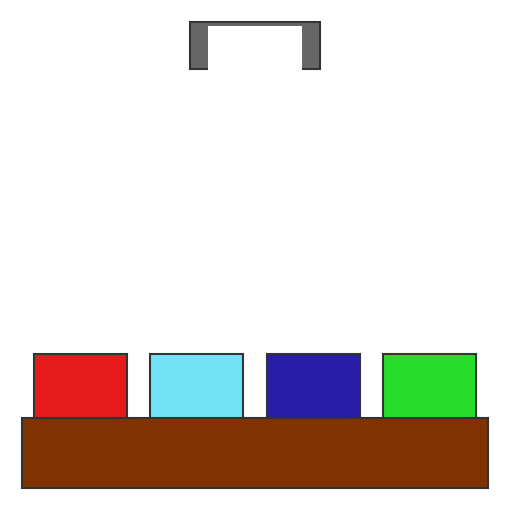

In [9]:
env = pddlgym.make("PDDLEnvBlocks-v0", seed=2) #Create the Blocks environment, use seed to ensure consistency
obs, debug_info = env.reset() #Reset and Initialize the environment
img = env.render() #Render the first frame
print(img.shape)

(480, 480, 4)


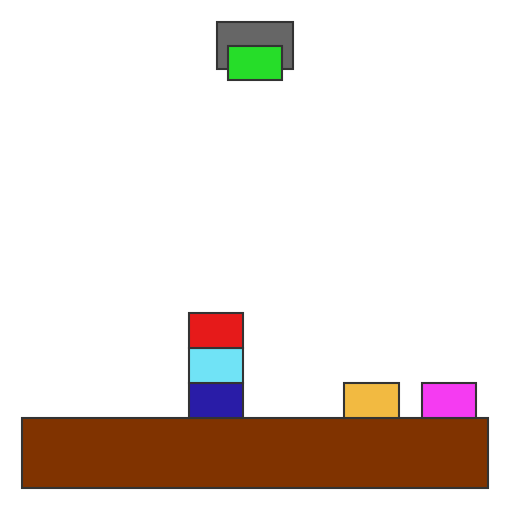

In [10]:
env = pddlgym.make("PDDLEnvBlocks-v0", seed=1) #Create the Blocks environment, use seed to ensure consistency
obs, debug_info = env.reset() #Reset and Initialize the environment
img = env.render() #Render the first frame
print(img.shape)

Each of the elements of the *img* array are tuples of 4 dimensions as dictated by the **RGBA** color model (https://en.wikipedia.org/wiki/RGBA_color_model). The first 3 dimensions represent the values for the Red, Green and Blue colors, while the value on position 4 represents the alpha channel and controls the opacity of the color. It can be observed that the alpha value for all pixels in the pictures are set to the maximum value of 255 (meaning all pixels are fully opaque) thus it can be safely ignored.

In [11]:
alpha_values = img[:, :, 3]

min_value = alpha_values.min()
max_value = alpha_values.max()

print(f"Alpha range: [{min_value}, {max_value}]")

Alpha range: [255, 255]


In [12]:
r_values = img[:, :, 0]
g_values = img[:, :, 1]
b_values = img[:, :, 2]

min_value_r = r_values.min()
max_value_r = r_values.max()

min_value_g = g_values.min()
max_value_g = g_values.max()

min_value_b = b_values.min()
max_value_b = b_values.max()

print(f"Red range: [{min_value_r}, {max_value_r}]")
print(f"Green range: [{min_value_g}, {max_value_g}]")
print(f"Blue range: [{min_value_b}, {max_value_b}]")

Red range: [38, 255]
Green range: [26, 255]
Blue range: [0, 255]


The dataset that will be used consists of a training and testing subset. An initial split of 80-20 was chosen, with around 800 images for the training set and 200 images for the test set. Each image was generated by having the agent perform a random walk, ensuring that every action they were taking resulted in a different state (which incurs a negligent overhead, as it needs to be manually tested). This reassurance was made possible by comparing the true literals of the previous state to those of the current after the action was made, as it is impossible for two different states to have exactly the same predicates being true.

In order to create the labels which correspond to each image, the objects as well as the predicates of the domain must be provided. For every image, a list with length equal to all valid combinations of predicates and arguments is created and then filled based on which predicates the PDDLGym dictates as true in each state (labelled with 1), while all others are labelled as false (0).

In [13]:
obs.objects #Print the names of all the objects of the domain

frozenset({a:block, b:block, c:block, d:block, e:block, f:block, robot:robot})

Above is the list of all objects, namely the 6 blocks as well as the robot.

In [14]:
obs.literals #Print all the true literals at the certain state

frozenset({clear(a:block),
           clear(e:block),
           clear(f:block),
           handfull(robot:robot),
           holding(d:block),
           on(a:block,b:block),
           on(b:block,c:block),
           ontable(c:block),
           ontable(e:block),
           ontable(f:block)})

The PDDLGym does not provide an automated manner of viewing all possible predicates of a domain. The $\textit{literals}$ instance provides only an insight on the true predicates, if a predicate is completely false, however, it could be easily missed. To mitigate this issue, the PDDLGym files were examined, as instructed by the documentation in their paper (https://arxiv.org/pdf/2002.06432.pdf), and the following predicates were identified:

- *on*(x-block ,y-block) : is true only when block x is on top of block y
- *ontable*(x-block) : is true only when block x is directly on the table (not on top of another block)
- *clear*(x-block) : is true only when block x has no other blocks on top of it and is not held by the robot
- *handempty*(x-robot) : is true only when the robot is not holding a block
- *handfull*(x-robot) : is true only when the robot is holding a block
- *holding*(x-block): is true only when the robot is holding block x)

Since the *handempty* and *handfull* predicates are mutually exclusive and their information is contained within the *holding* predicate, it was decided that these two predicates will not be used. Although the robot object would not be a valid option for the remaining predicates, we still decided to included in the detected objects and predicates' arguments for completeness purposes.

A function that performs this predicate extraction for a single state is created below

In [15]:
def extract_grounded_predicates(env):
    state = env.get_state() #Get the current state object

    objects = list(state.objects) #Get a list of the objects of the domain

    objects = sorted(objects) #Sort the list to ensure consistency

    literals = state.literals #Get a list of the true predicates of the domain
    
    all_predicates = []

    for object_1 in objects: #Create all unary predicates's combinations
        all_predicates.append('holding(' + object_1 + ')')
        all_predicates.append('clear(' + object_1 + ')')
        all_predicates.append('ontable(' + object_1 + ')')

    for object_1 in objects: #Create the binary predicate combinations
        for object_2 in objects:
            all_predicates.append('on(' + object_1 + ',' + object_2 + ')')

    predicate_labels = [0 for item in all_predicates] #Set all labels to false

    literals_list = list(literals)
    literals_string_list = []
    for lit in literals_list:
        literals_string_list.append(str(lit))
    for i, predicate in enumerate(all_predicates):
        if predicate in literals_string_list:
            predicate_labels[i] = 1 #Change all labels whose predicate is found in the true predicate list to 1


    return objects, all_predicates, predicate_labels #Returns the list of objects, the list of predicates and the labels

In [16]:
objects, preds, labels = extract_grounded_predicates(env)

Since there are 7 objects, the number of possible predicates should be $3N + N^2$ predicates, where $N$ is the number of objects, meaning 70 predicates in this case.

In [17]:
len(preds)

70

## Object - Color Matching

In [19]:
objects

[a:block, b:block, c:block, d:block, e:block, f:block, robot:robot]

Since the objects as they are extracted from the PDDLGym folder are named with letters ranging from a to b, as well as an object for the robot, there is no robust way to discover which object is assigned which color. This object-color matching is necessary both for the creation of the Graph Neural Network, as well as for testing the Convolutional Neural Network responsible for identifying the position of the objects.

Examining the source code of PDDLGym, it becomes apparent that in the case of the BlocksWorld domain this color to object assignment happens at random. For this reason, the following line was added to the $\text{get\_objects\_from\_obs(obs)}$ function of the BlocksWorld domain in the PDDLGym source folders, which is located at the folder: *pddlgym\rendering\blocks.py* . A snippet including this function is included in the notebook for completenes.

In [20]:
def get_objects_from_obs(obs):
    on_links = {}
    pile_bottoms = set()
    all_objs = set()
    holding = None
    for lit in obs:
        if lit.predicate.name.lower() == "ontable":
            pile_bottoms.add(lit.variables[0])
            all_objs.add(lit.variables[0])
        elif lit.predicate.name.lower() == "on":
            on_links[lit.variables[1]] = lit.variables[0]
            all_objs.update(lit.variables)
        elif lit.predicate.name.lower() == "holding":
            holding = lit.variables[0]
            all_objs.add(lit.variables[0])
    all_objs = sorted(all_objs)

    bottom_to_pile = {}
    for obj in pile_bottoms:
        bottom_to_pile[obj] = [obj]
        key = obj
        while key in on_links:
            assert on_links[key] not in bottom_to_pile[obj]
            bottom_to_pile[obj].append(on_links[key])
            key = on_links[key]

    piles = []
    
    
    #---MY CODE------------------
    for item in all_objs:
        block_name_to_color(item)
    #---MY CODE------------------

    
    for pile_base in all_objs:
        if pile_base in bottom_to_pile:
            piles.append(bottom_to_pile[pile_base])
        else:
            piles.append([])

    return piles, holding

A function is created to help find all unique colors in the image

In [21]:
def find_unique_quadruples(img):
    unique_quadruples = set()  # Use a set to store unique quadruples
    
    # Iterate through each pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Extract the quadruple for the current pixel
            quadruple = tuple(img[i, j, :])
            unique_quadruples.add(quadruple)
    
    # Convert the set of unique quadruples back to a list
    unique_quadruples_list = list(unique_quadruples)
    return unique_quadruples_list

Another function is used to visualize each color

In [22]:
def create_images_for_quadruples(img, unique_quadruples):
    # Calculate the grid size for the subplots
    num_images = len(unique_quadruples)
    grid_size = int(np.ceil(np.sqrt(num_images)))  # This creates a square-like layout
    
    # Create a figure with subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(30, 30))
    axes = axes.flatten()  # Flatten the axes array if it's 2D
    
    for index, quadruple in enumerate(unique_quadruples):
        # Create a white image of the same shape as the original image (img)
        white_img = np.ones_like(img) * 255
        
        # Iterate over each pixel in `img`
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                # Check if the current pixel matches the quadruple
                if all(img[i, j, :] == np.array(quadruple)):
                    # Set the pixel in `white_img` to the quadruple's color
                    white_img[i, j, :] = np.array(quadruple)
        
        # Display the image in the corresponding subplot
        axes[index].imshow(white_img)
        axes[index].set_title(f"Quadruple: {quadruple}")
        axes[index].axis('off')

    # Hide any unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
unique_colors = find_unique_quadruples(img)

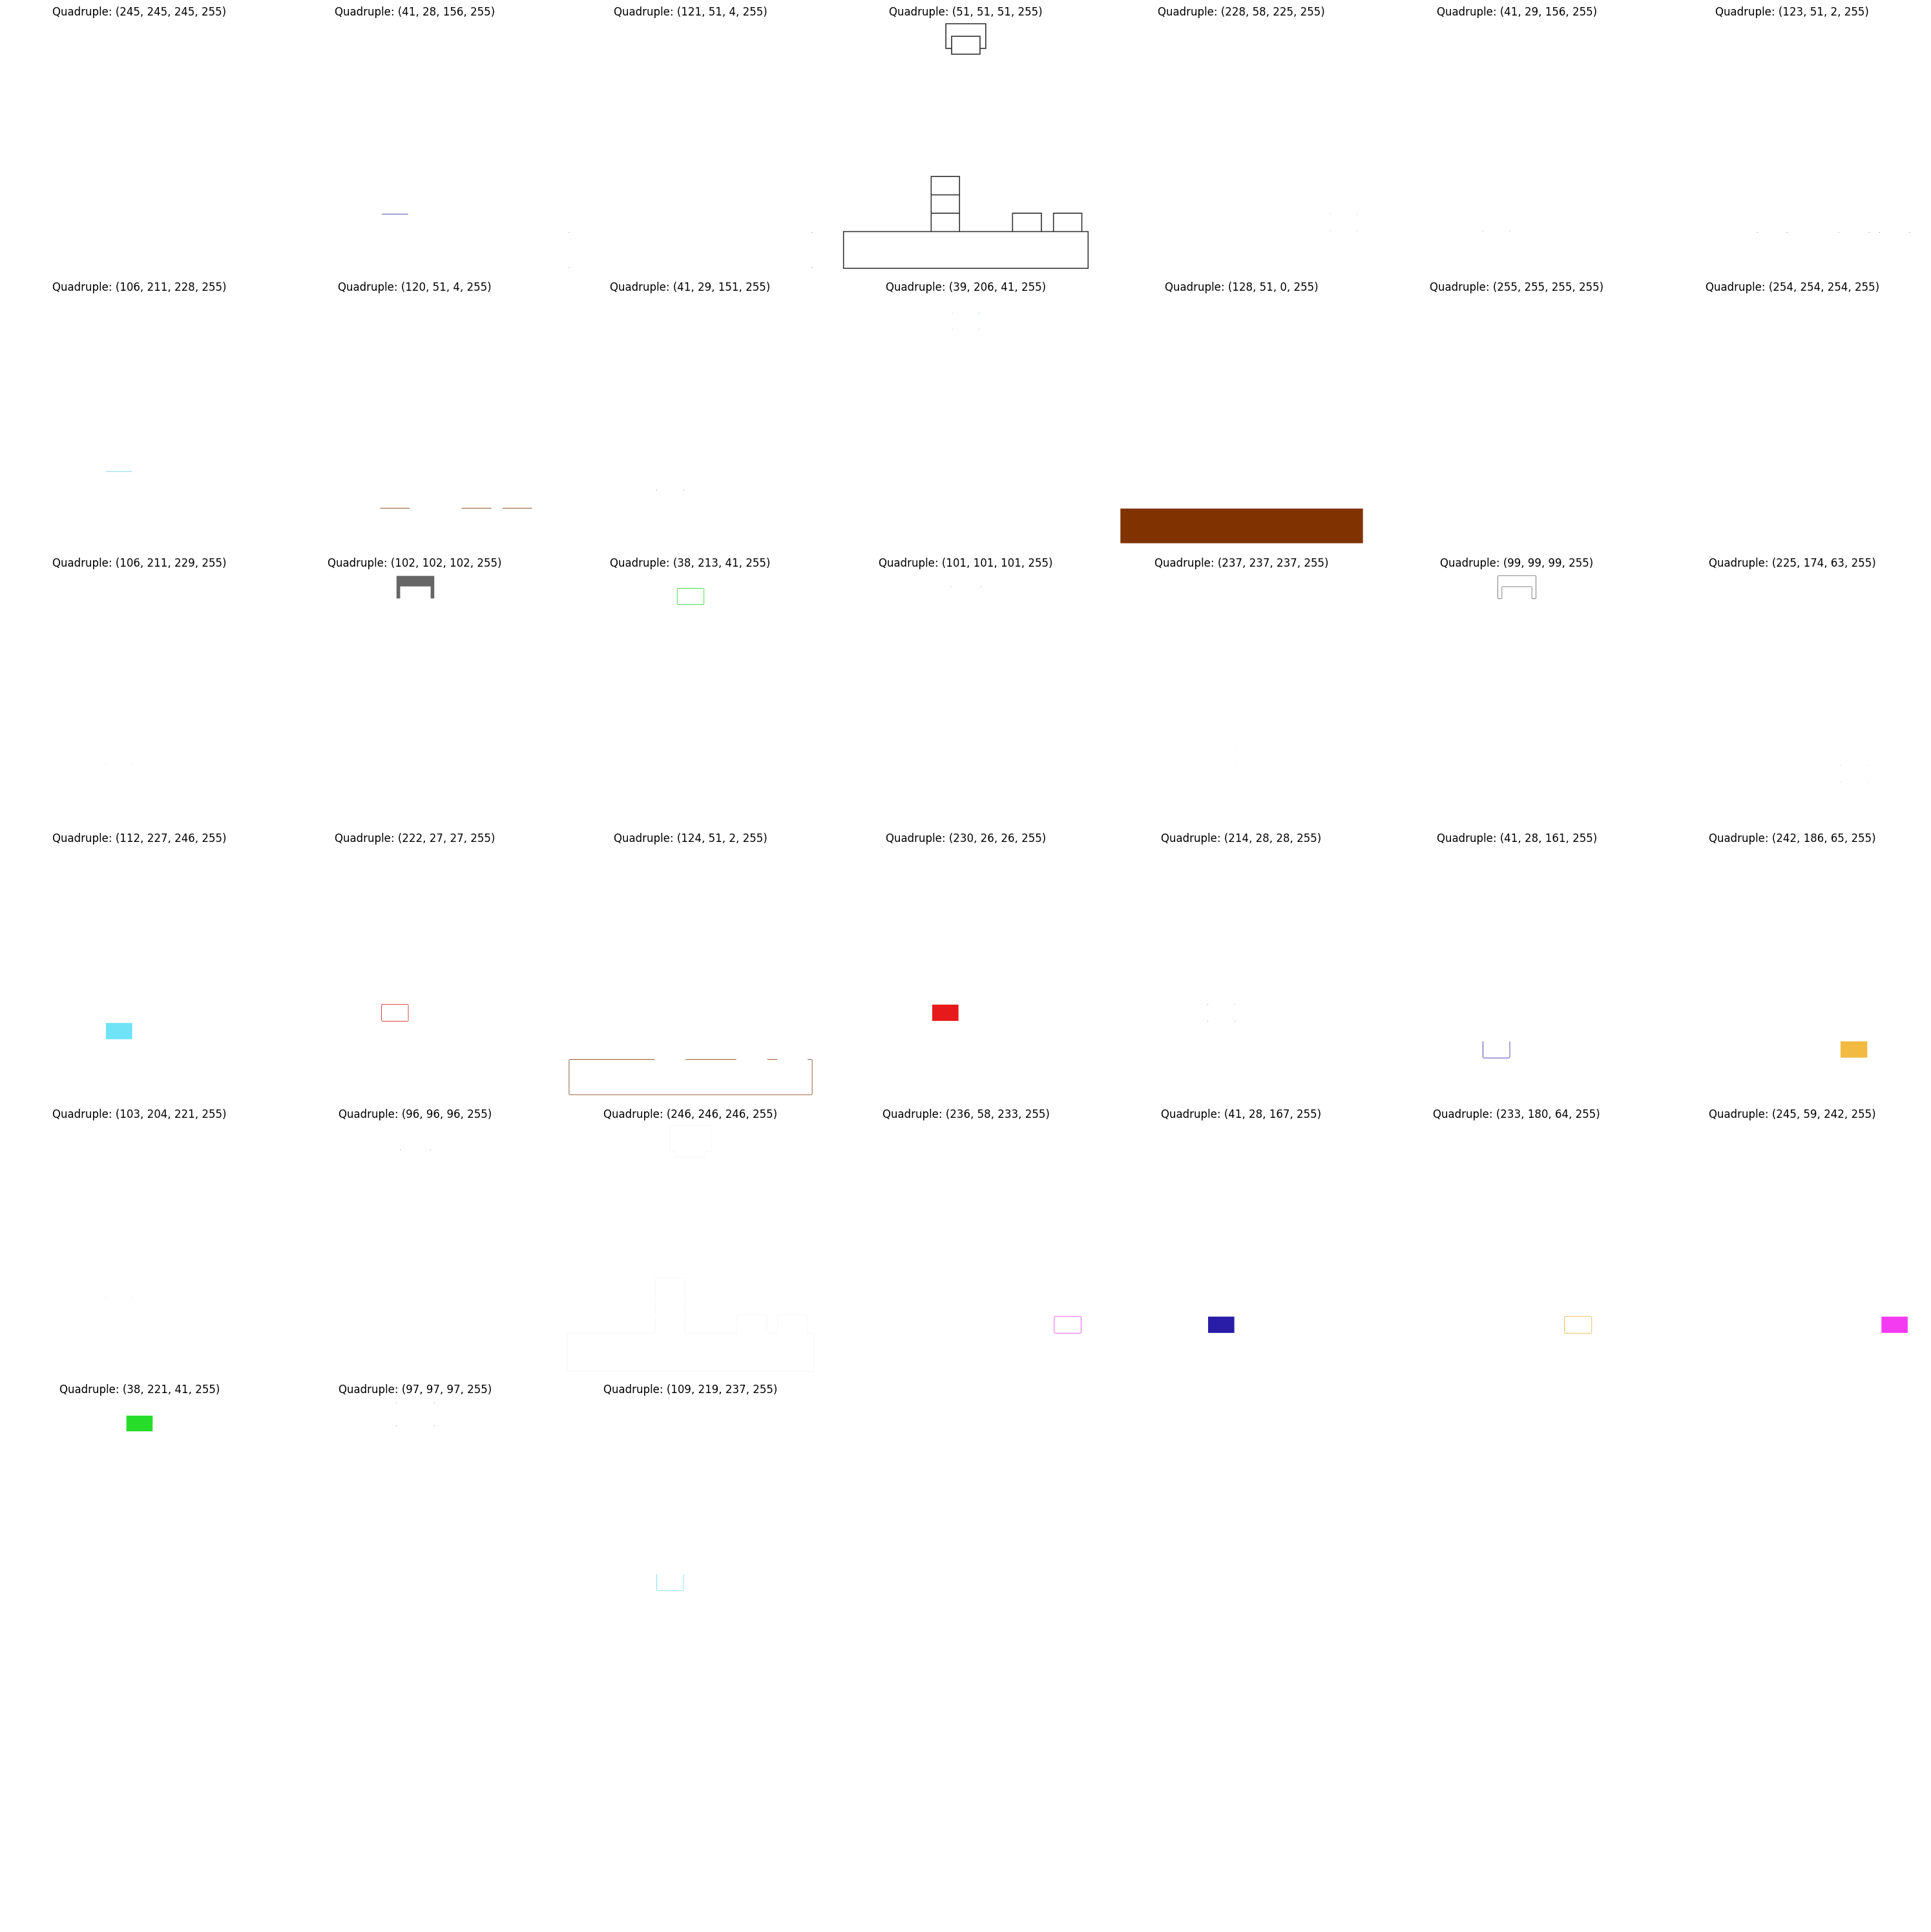

In [24]:
create_images_for_quadruples(img, unique_colors)

As can be seen, the corresponding colors for the blocks and robot are:

- Robot: [102, 102, 10, 255]
- Red block : [230, 26, 26, 255]
- Turqoise block: [112, 227, 246, 255]
- Blue block: [41, 28, 167, 255]
- Green block: [38, 221, 41, 255]
- Yellow block: [242, 186, 65, 255]
- Fuchsia block: [245, 59, 242, 255]

We also need to match the color codes to the blocks. In order to do that, we will infer the matching from the literals

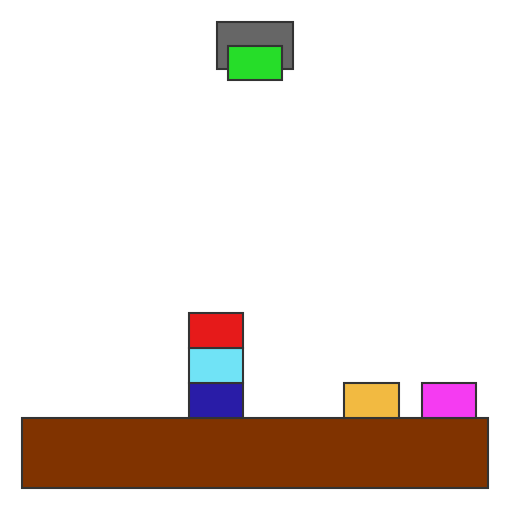

In [25]:
obs.literals
img = env.render()

Since the robot is holding d-block, that means the green block is d-block. In addition, using the $\textit{on}$ predicate, we can infer that a-block is on top of b-block which is on top of c-block. Thus, the red block is a-block, the turqoise (light blue) block is b-block and the blue block is c-block. It is impossible to infer which of the remaining two blocks is the e- and f-block, thus we will take two steps and observe the changes in the predicates.

In [26]:
env.action_space.seed(1) #Ensure that we always get the same sequence of actions

[1]

frozenset({on(b:block,c:block), on(a:block,b:block), ontable(c:block), clear(a:block), on(d:block,e:block), handfull(robot:robot), ontable(e:block), clear(d:block), holding(f:block)})


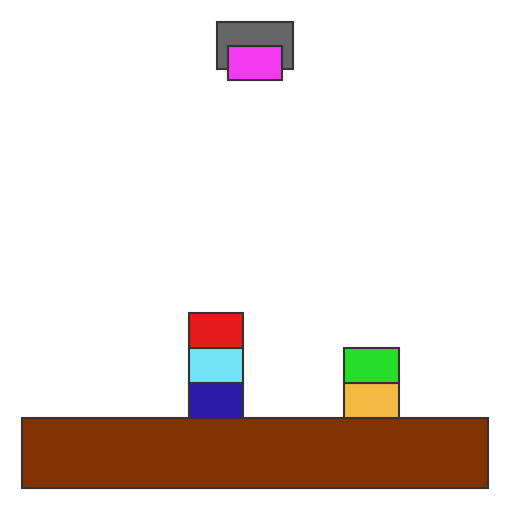

In [27]:
for k in range(2):

    true_predicates = obs.literals
    next_predicates = obs.literals
    while(true_predicates == next_predicates):
        action = env.action_space.sample(obs)
        obs, reward, done, info = env.step(action)
        true_predicates = next_predicates.copy()
        next_predicates = obs.literals
img = env.render()
print(obs.literals)

From the updated $\textit{holding}$ predicate, it can be inferred that the fuchsia block is the f-block and thus the yellow block is the e-block. Utilizing this knowledge, the following constants are defined.

Changing the code in the PDDLGym files ensures that the blocks will always get the same color, even if their number is less than 6 (which is the maximum value).

In [29]:
ROBOT_COLOR    = [102, 102, 102,  255]
RED_COLOR      = [230, 26,  26,  255] #block a
TURQOISE_COLOR = [112, 227, 246, 255] #block b
BLUE_COLOR     = [41,  28,  167, 255] #block c
GREEN_COLOR    = [38,  221, 41,  255] #block d
YELLOW_COLOR   = [242, 186, 65,  255] #block e
FUCHSIA_COLOR  = [245, 59,  242, 255] #block f

ALL_COLORS = []


ALL_COLORS.append(RED_COLOR) #a
ALL_COLORS.append(TURQOISE_COLOR) #b
ALL_COLORS.append(BLUE_COLOR) #c
ALL_COLORS.append(GREEN_COLOR) #d
ALL_COLORS.append(YELLOW_COLOR) #e
ALL_COLORS.append(FUCHSIA_COLOR) #f
ALL_COLORS.append(ROBOT_COLOR)

ALL_COLORS = np.array(ALL_COLORS)

In [31]:
def create_feature_maps(img, ALL_COLORS):

    feature_maps = np.zeros((480, 480, 7), dtype='b') #Initialize the mask
    
    for i, color in enumerate(ALL_COLORS):
        
        matches = np.all(img == color, axis=-1) # Find pixels exactly matching the current color
        
        feature_maps[:, :, i] = matches # Update the corresponding mask

    return feature_maps

# Dataset Creation

In order to generate the dataset, we will have the agent perform a variation of a random walk. The variation lies in the fact that, for every step we will have the agent perform actions at random until an action that can actually take effect is performed, thus reducing multiple redundant images of the same state. It can be shown that, on average, one every 18 actions arrives at a different state if we allow complete randomness. It should be noted that this is a limitation of the PDDLGym, as sampling an action is equivalent to randomly picking an action out of all actions available in the domain (possible or not).

In [32]:
steps_between_different_actions = []

for k in range(10000):
    steps_counter = 0
    current_predicates = obs.literals #Initialize current true predicates
    next_predicates = obs.literals #Initialize next true predicates (equal to current here)
    while(current_predicates == next_predicates): #While the State does not change
        action = env.action_space.sample(obs) #Choose an action randomly
        obs, reward, done, info = env.step(action) #Perform the action
        current_predicates = next_predicates.copy() #Change the current predicates to the previously "next" ones
        next_predicates = obs.literals #Update the next predicates
        steps_counter += 1
    steps_between_different_actions.append(steps_counter)

print(f'On average, a different action occurs every: {np.average(steps_between_different_actions)} steps.')

On average, a different action occurs every: 18.2148 steps.


For every step, the image will be saved, as well as a numpy array of shape $(480,480,7)$, where every of the 7 dimensions will be a numpy array (representing an object detection "mask" of the image) filled with 0s, apart from the place where the corresponding object (block or robot) will lie, which will be filled with 1s.

This structure is the expected output of the object detection CNN (which is the first step of the pipeline) and will only be used to test the Convolutional Neural Network separately to ensure its architecture is functional.

In addition, we will also append create a Pandas DataFrame containing the truth values of the predicates as rows, representing the label for each image, which will be used for the training of the whole pipeline.

In [33]:
RANDOM_WALK_STEPS_TRAIN = 80 #Placeholder number, replace with actual
RANDOM_WALK_STEPS_TEST  = 20 #Placeholder number, replace with actual

In [34]:
def save_image_and_mask(img, feature_maps, step, train=True):
    
    if train:
        output_dir = f'dataset_blocks/train/images/' #Create the training directory for the images
    else:
        output_dir = f'dataset_blocks/test/images/' #Create the test directory for the images
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    imageio.imsave(os.path.join(output_dir, f'image_{(step)}.png'), img) #Save the image

    if train:
        labels_output_dir = f'dataset_blocks/train/masks/' #Create the training directory for the masks
    else:
        labels_output_dir = f'dataset_blocks/test/masks/' #Create the training directory for the masks
    
    if not os.path.exists(labels_output_dir):
        os.makedirs(labels_output_dir)

    np.save(os.path.join(labels_output_dir, f'mask_{step}'), feature_maps) #Save the mask

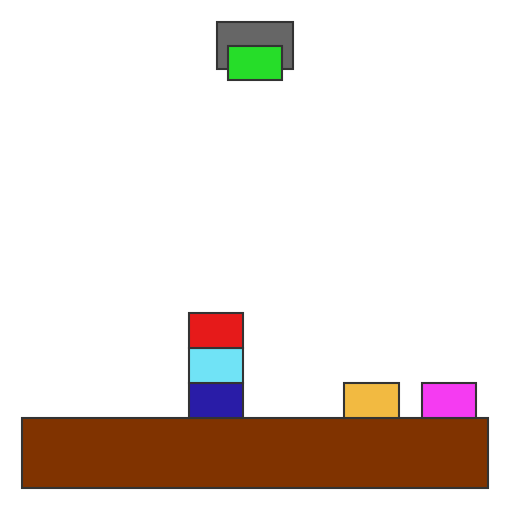

In [35]:
env = pddlgym.make("PDDLEnvBlocks-v0", seed=1) #Create the environment
env.action_space.seed(1) #Ensure that we always get the same sequence of actions
obs, debug_info = env.reset() #Reset and Initialize the environment
img = env.render() #Render the first image

In [36]:
CREATE_DATASET = False #Change to True to create the dataset

In [37]:
if CREATE_DATASET:
    feature_maps = create_feature_maps(img, ALL_COLORS) #Extract the first set of masks of the image

    save_image_and_mask(img, feature_maps, 1, True) #Save the first image and masks

    _ , literals, predicate_labels = extract_grounded_predicates(env) #Extract the predicates as well as their values

    labels_train = []
    labels_train.append(predicate_labels)

    plt.close() #Close the image to save memory

    for step in range(1, RANDOM_WALK_STEPS_TRAIN): #Perform the random walk
        current_predicates = obs.literals
        next_predicates = obs.literals
        while(current_predicates == next_predicates):
            action = env.action_space.sample(obs)
            obs, reward, done, info = env.step(action)
            current_predicates = next_predicates.copy()
            next_predicates = obs.literals

        img = env.render()
        plt.close() #Close the image to save memory

        feature_maps = create_feature_maps(img, ALL_COLORS) 

        save_image_and_mask(img, feature_maps, step+1, True)
            
        _, literals, predicate_labels = extract_grounded_predicates(env)
        labels_train.append(predicate_labels)

    labels_train_df = pd.DataFrame(labels_train, columns=literals) #Create a dataframe with the labels
    labels_train_df.to_csv(f'dataset_blocks/train/labels.csv', index=False, sep=';') #Save the dataframe

    #---Create Test Dataset---#
    
    labels_test = []

    for step in range(1, RANDOM_WALK_STEPS_TEST): #Perform the random walk

        current_predicates = obs.literals
        next_predicates = obs.literals
        while(current_predicates == next_predicates):
            action = env.action_space.sample(obs)
            obs, reward, done, info = env.step(action)
            current_predicates = next_predicates.copy()
            next_predicates = obs.literals
        img = env.render()

        feature_maps = create_feature_maps(img, ALL_COLORS)

        save_image_and_mask(img, feature_maps, step+1, False)

        _, literals, predicate_labels = extract_grounded_predicates(env)
        labels_test.append(predicate_labels)

        plt.close('all')

    labels_test_df = pd.DataFrame(labels_test, columns=literals)
    labels_test_df.to_csv('dataset_blocks/test/labels.csv', index=False, sep=';')

In [38]:
plt.close('all')

Creating the dataset takes a time of magnitude around 30 minutes, thus we will be utilizing the already created dataset, consisting of 8000 images for the training set and 2000 images for the test set.

In [51]:
train_labels_df = pd.read_csv('labels_train.csv', sep=';')

In [52]:
test_labels_df = pd.read_csv('labels_test.csv', sep=';')

In [55]:
labels_df = pd.concat([train_labels_df, test_labels_df])

In [57]:
duplicate = labels_df[labels_df.duplicated()]
print(duplicate.shape)

(7402, 70)


In [58]:
labels_df = labels_df.drop_duplicates()

In [59]:
x = list(labels_df.sum(axis=1)) #Count how many predicates are true in each state

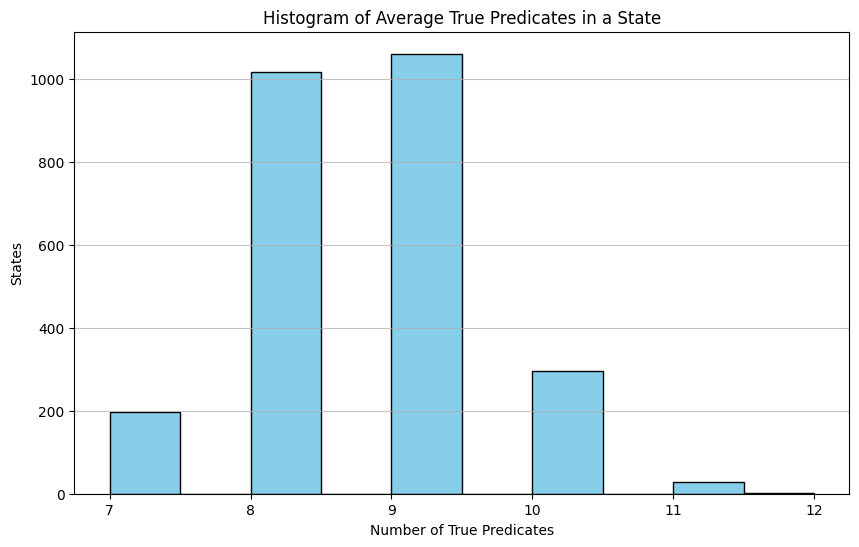

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(x, color='skyblue', edgecolor='black')
plt.title('Histogram of Average True Predicates in a State')
plt.xlabel('Number of True Predicates')
plt.ylabel('States')
plt.grid(axis='y', alpha=0.75)
plt.show()

It can be observed that, on average, 8 to 9 predicates are true in every state, indicating that only 11-13% of the label vectors are filled with non-zero values. Thus, these vector can be considered marginally sparse. This fact is expected to be an issue during training, as the error must be back-propagated throughout the whole network, and for each sample 70 differences must be calculated.

Next, we will also graph the frequencies in which each predicate is true in the dataset. To do so, we sum across all rows to obtain a single row containing each predicate's frequency

In [79]:
frequencies = labels_df.sum(axis=0) #Calculate frequencies

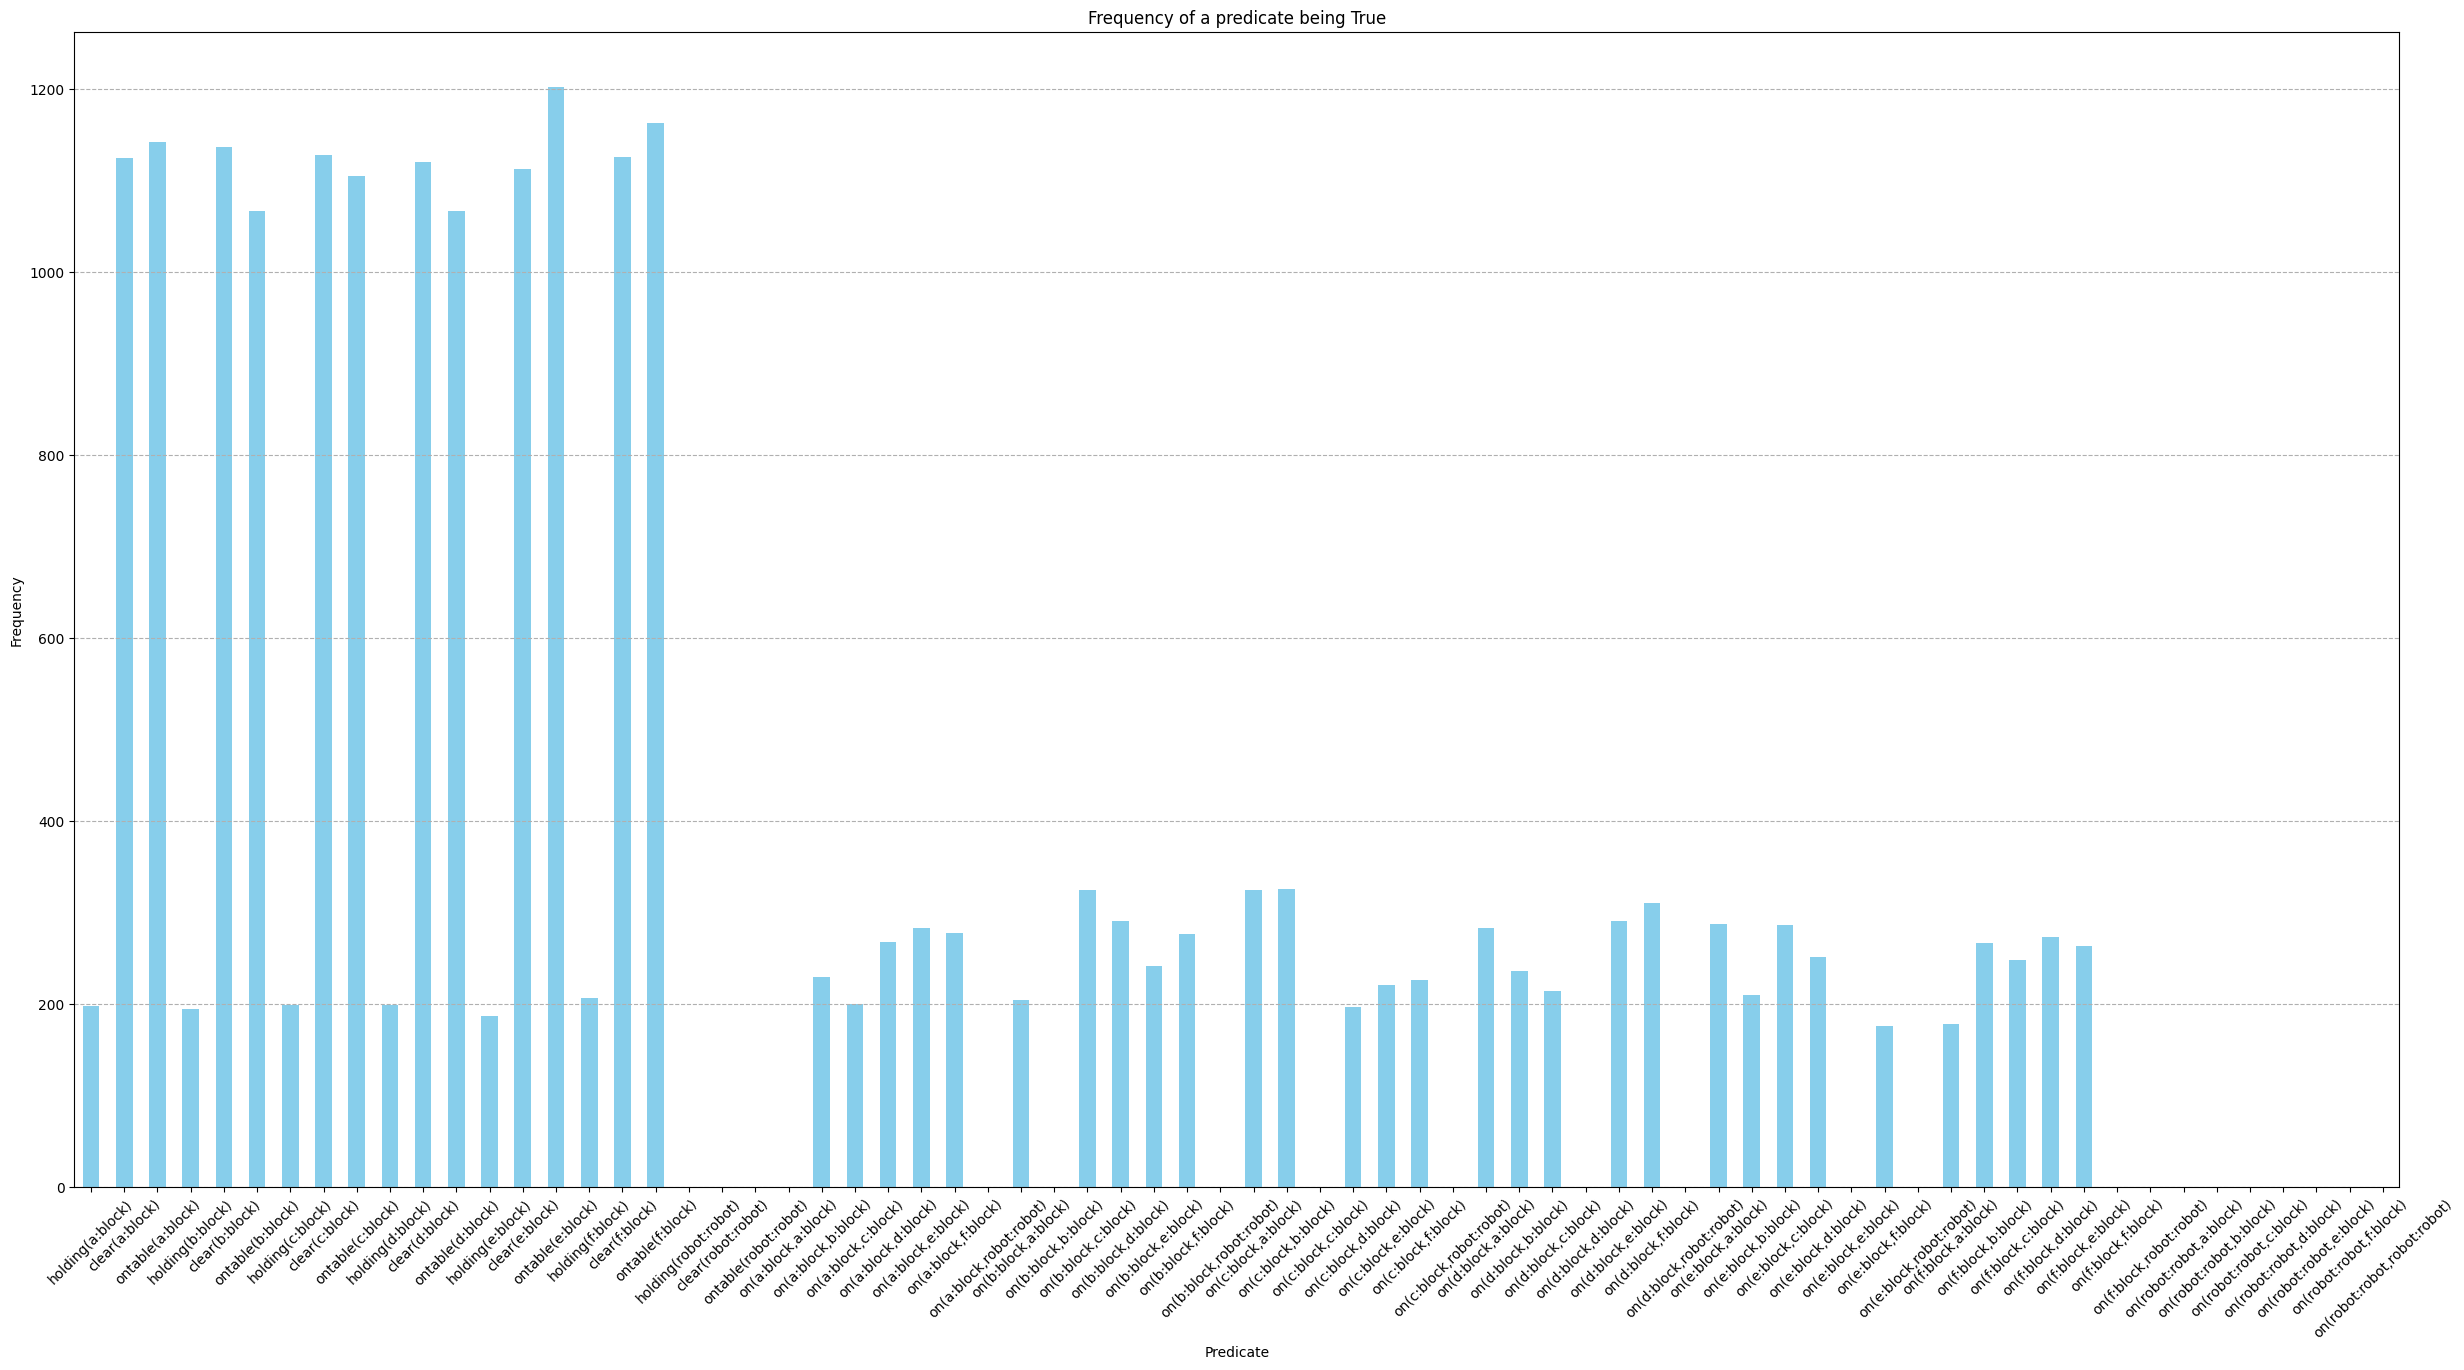

In [80]:
plt.figure(figsize=(30, 15))
frequencies.plot(kind='bar', color='skyblue')
plt.title('Frequency of a predicate being True')
plt.xlabel('Predicate')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

Observing the graph it becomes apparent that some predicates are never true. This is expected, considering some predicates were only included for completenes, such as the robot holding itself or any block being on top of itself. These predicates are:

In [82]:
frequencies[frequencies == 0] #Find out which predicates are never true

holding(robot:robot)           0
clear(robot:robot)             0
ontable(robot:robot)           0
on(a:block,a:block)            0
on(a:block,robot:robot)        0
on(b:block,b:block)            0
on(b:block,robot:robot)        0
on(c:block,c:block)            0
on(c:block,robot:robot)        0
on(d:block,d:block)            0
on(d:block,robot:robot)        0
on(e:block,e:block)            0
on(e:block,robot:robot)        0
on(f:block,f:block)            0
on(f:block,robot:robot)        0
on(robot:robot,a:block)        0
on(robot:robot,b:block)        0
on(robot:robot,c:block)        0
on(robot:robot,d:block)        0
on(robot:robot,e:block)        0
on(robot:robot,f:block)        0
on(robot:robot,robot:robot)    0
dtype: int64

We can filter out these predicates and graph only those with a positive value.

In [83]:
frequencies_nonzero = frequencies[frequencies != 0] #Filter out predicates with a value equal to 0

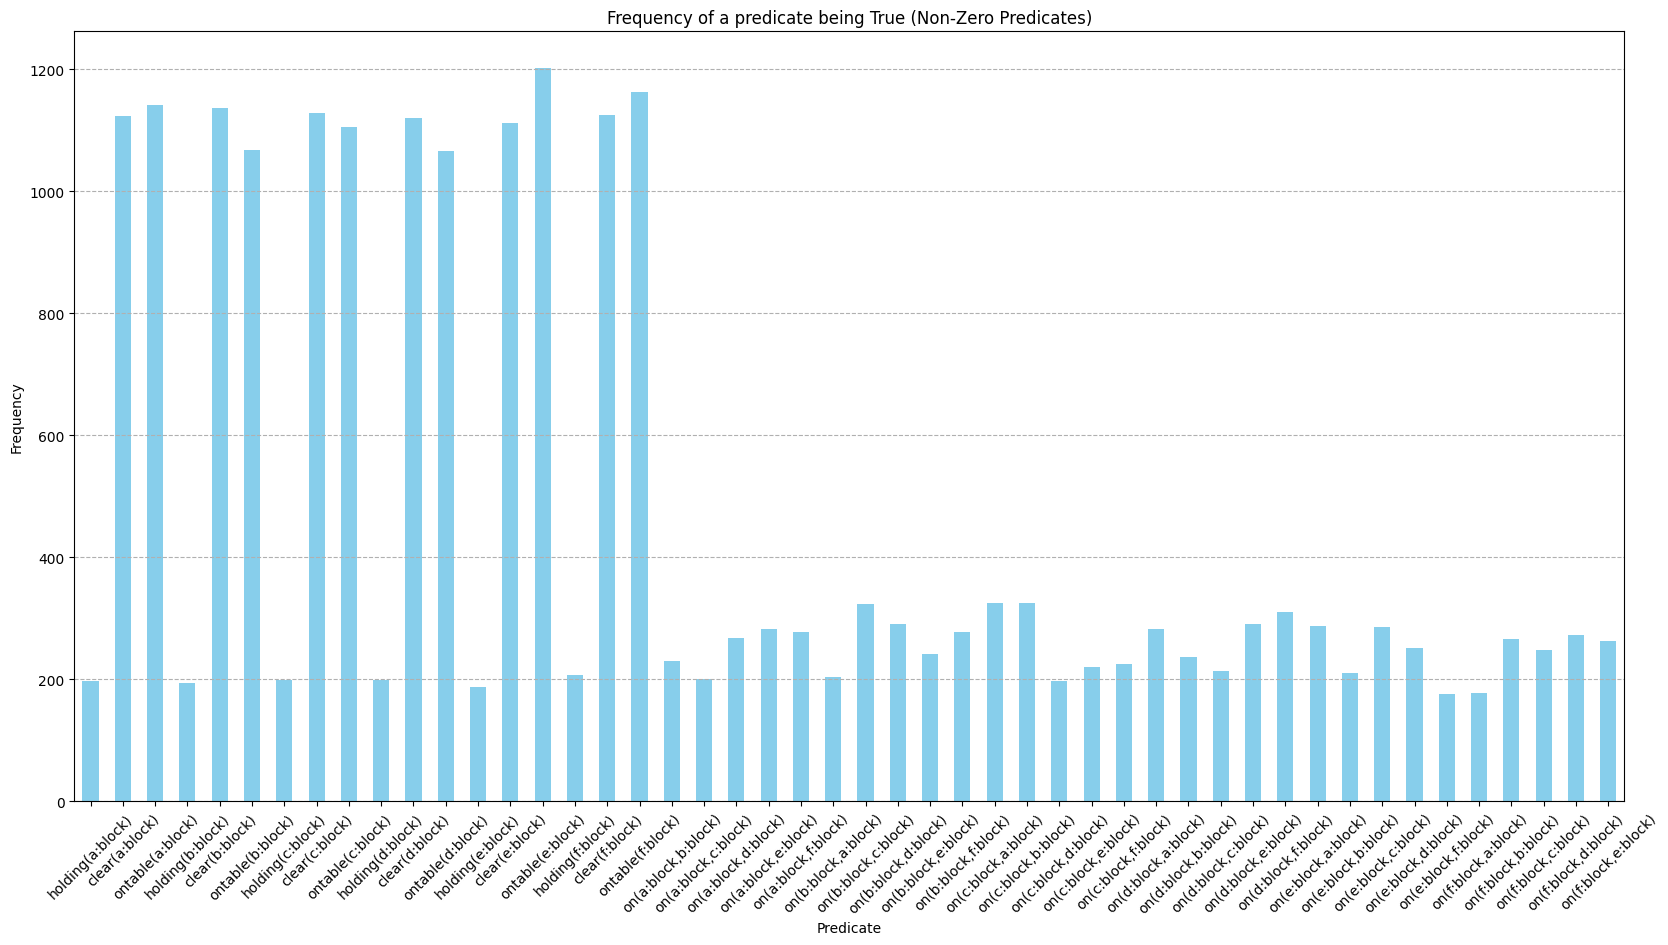

In [85]:
plt.figure(figsize=(20, 10))
frequencies_nonzero.plot(kind='bar', color='skyblue')
plt.title('Frequency of a predicate being True (Non-Zero Predicates)')
plt.xlabel('Predicate')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

As can be seen, the $\textit{clear}$ and $\textit{ontable}$ predicates are true almost 5 times more than any other predicate. This is again expected, as every action can only affect at most two blocks (the block that is being held and the one the held block is placed on top of). All other predicates appear with approximately the same frequency. It is expected that, in an even larger dataset, the most frequent predicates would again be $\textit{clear}$ and $\textit{ontable}$ while the other predicates would approximately show similar frequency, except for the $\textit{holding}$ predicate, as only one block can be held at a time.